In [1]:
#import relevant packages
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
#read in clustered data
data = pd.read_csv("fcc_comments_clustered.csv")

In [3]:
#calculate silhouette scores
features = data.iloc[:,-384:]
labels = data["cluster_id"]
silhouette_score = silhouette_score(features,labels)
silhouette_samp_scores = silhouette_samples(features,labels)

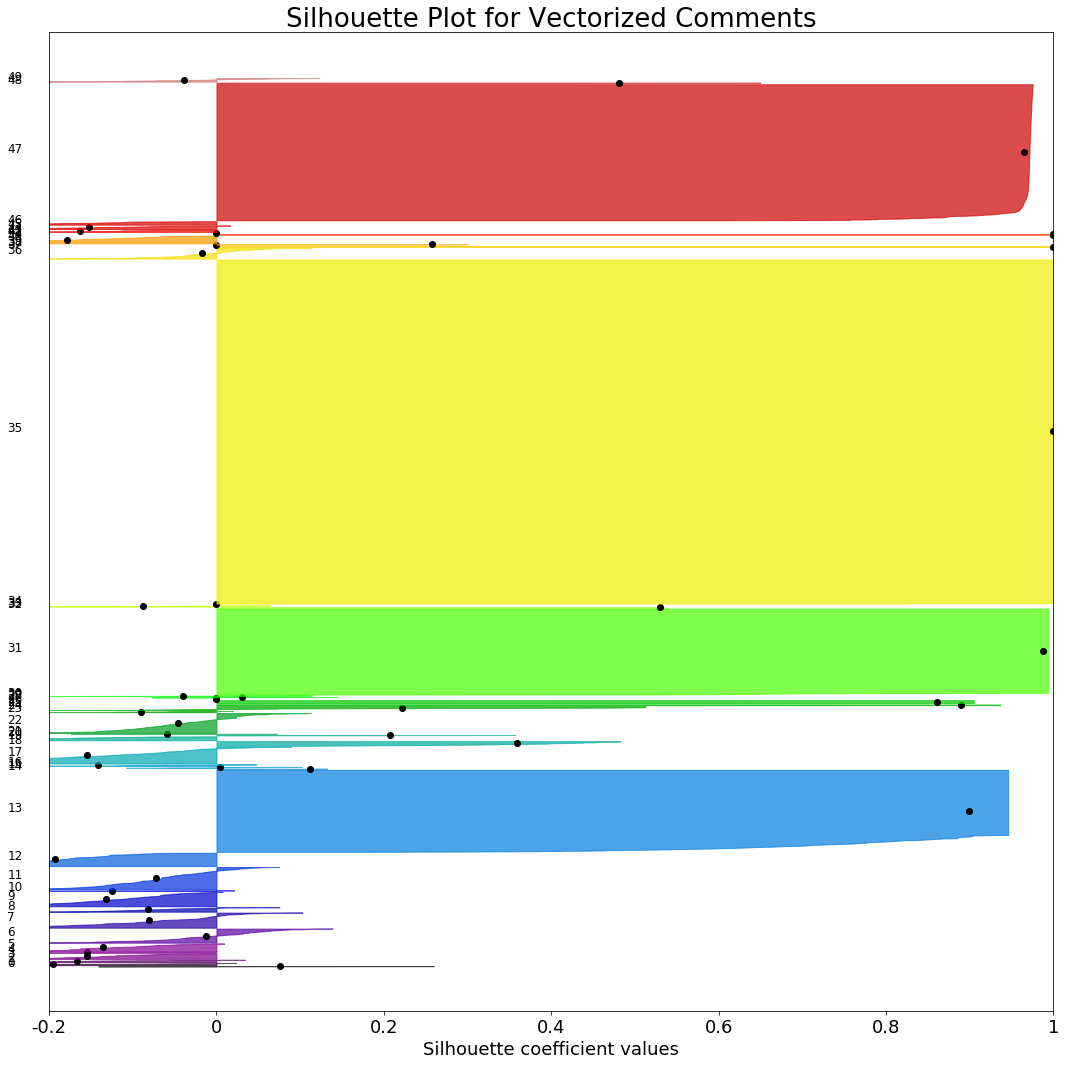

In [13]:
#used code from here to make silhouette plots:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
fig,ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

ax1.set_xlim([-0.2, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
n_clusters = 50
#ax1.set_ylim([0, len(features) + (n_clusters + 1) * 10]);

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        silhouette_samp_scores[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.25, y_lower + 0.5 * size_cluster_i, str(i),fontsize=12)
    
    # A dab at the average silhouette score for cluster i (Kao)
    ax1.scatter(x=ith_cluster_silhouette_values.mean(), y=y_lower + 0.5 * size_cluster_i, color='k');

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
ax1.set_title("Silhouette Plot for Vectorized Comments",fontsize=26)
ax1.set_xlabel("Silhouette coefficient values",fontsize=18)

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1],fontsize=18);

In [17]:
#find signature strings for each cluster
sig_strings = pd.DataFrame()
sig_strings["cluster_id"] = np.arange(0,labels.max()+1)
comm_list = list()
sil_mean = list()

for ii in range(labels.max()+1):
    text = data[data["cluster_id"] == ii].reset_index(drop=True)
    ind = np.random.randint(0,len(text))
    comm_list.append(text["text_data"][ind])
    ith_cluster_silhouette_values = silhouette_samp_scores[labels == ii]
    sil_mean.append(ith_cluster_silhouette_values.mean())

sig_strings["mean silhouette score"] = sil_mean
sig_strings["text_data"] = comm_list

In [18]:
cluster_mean_sil = dict()
for ii in range(len(sig_strings)):
    cluster_mean_sil[sig_strings["cluster_id"][ii]] = sig_strings["mean silhouette score"][ii]
    
cluster_means = list()
for jj in range(len(data)):
    cluster_means.append(cluster_mean_sil[data["cluster_id"][jj]])

In [19]:
data2 = pd.DataFrame()
data2["mean silhouette score"] = cluster_means
data2["silhouette_score"] = silhouette_samp_scores

In [20]:
views = [1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,2,1,
        1,0,1,1,1,0,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1]

cluster_views = dict()
for ii in range(len(sig_strings)):
    cluster_views[sig_strings["cluster_id"][ii]] = views[ii]
    
nn_stance = list()
for jj in range(len(data)):
    nn_stance.append(cluster_views[data["cluster_id"][jj]])
    
data2["net neutrality"] = nn_stance
data2 = pd.concat([data["cluster_id"],data2["silhouette_score"],data2["mean silhouette score"],
                   data2["net neutrality"],data["confirmation_number"],data["text_data"]],axis=1)
data2.to_csv("fcc_comments_cluster_silmean.csv")

In [21]:
#calculate number of comments per cluster
comm_counts = list()
for jj in range(50):
    val = 0
    for ii in range(len(data["cluster_id"])):
        if data["cluster_id"][ii] == jj:
            val = val + 1
    comm_counts.append(val)

In [22]:
colors = list()
for view in views:
    if view == 1:
        colors.append('g')
    elif view == 0:
        colors.append('r')
    else:
        colors.append('b')

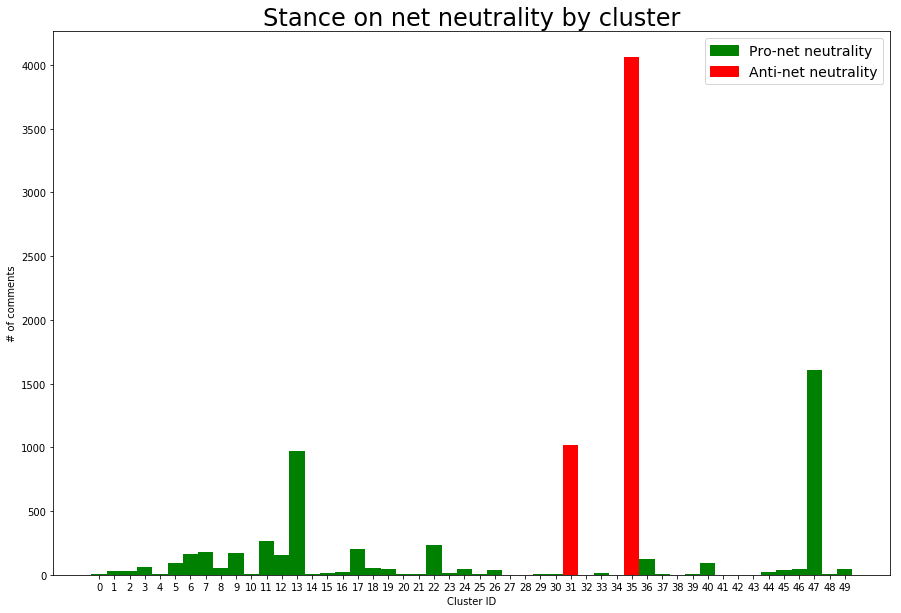

In [23]:
fig2 = plt.figure(figsize=(15,10))

plt.bar(np.arange(0,50),comm_counts,width=1,color=colors)
plt.xticks(np.arange(0,50,1))
plt.xlabel("Cluster ID")
plt.ylabel("# of comments")
#Kao
patch1 = mpatches.Patch(color='g', label='Pro-net neutrality')
patch2 = mpatches.Patch(color='r', label='Anti-net neutrality')
plt.legend(handles=[patch1,patch2],fontsize=14)
plt.title("Stance on net neutrality by cluster",fontsize=24);